#### Meu Projeto 
#### Regras de Associação e Market Basket Analysis

#### Pacotes

In [1]:
import numpy as np
import pandas as pd
import efficient_apriori
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from itertools import combinations
from efficient_apriori import apriori
import warnings
warnings.filterwarnings('ignore')

#### Carregando os dados

In [2]:
df_corredores = pd.read_csv('data/raw/corredores.csv')
df_departamentos = pd.read_csv('data/raw/departamentos.csv')
df_pedidos = pd.read_csv('data/raw/pedidos.csv')
df_produtos = pd.read_csv('data/raw/produtos.csv')
df_transacoes = pd.read_csv('data/raw/transacoes.csv')

### Análise Exploratória
#### Detalhes do Tamanho de Cada Dataset via Programação

In [3]:
# Total de registros por datasets
contagem_arrays = np.array([
    ['df_corredores', len(df_corredores)],
    ['df_departamentos', len(df_departamentos)],
    ['df_pedidos', len(df_pedidos)],
    ['df_produtos', len(df_produtos)],
    ['df_transacoes', len(df_transacoes)]
    ])

In [4]:
# Converte array em dataframe
contagem = pd.DataFrame(contagem_arrays, columns = ['Arquivo', 'Total de Registros'])

In [5]:
print(contagem)

            Arquivo Total de Registros
0     df_corredores                134
1  df_departamentos                 21
2        df_pedidos            3421083
3       df_produtos              49688
4     df_transacoes           32434489


In [6]:
df_corredores.shape

(134, 2)

In [7]:
df_corredores.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
df_departamentos.shape

(21, 2)

In [9]:
df_departamentos.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
df_pedidos.shape

(3421083, 7)

In [11]:
df_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
df_produtos.shape

(49688, 4)

In [13]:
df_produtos.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [14]:
df_transacoes.shape

(32434489, 4)

In [15]:
df_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Verificando Valores Ausentes

In [16]:
df_corredores.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [17]:
df_departamentos.isna().sum()

department_id    0
department       0
dtype: int64

In [18]:
df_pedidos.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [19]:
df_produtos.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [20]:
df_transacoes.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Reorganização dos Dados
#### Merge de tabelas

In [21]:
%%time
df_transacoes = df_transacoes.merge(df_pedidos, on='order_id', how='left')
df_transacoes = df_transacoes.merge(df_produtos, on='product_id', how='left')
df_transacoes = df_transacoes.merge(df_departamentos, on='department_id', how='left')
df_transacoes = df_transacoes.merge(df_corredores, on='aisle_id', how='left')

CPU times: total: 24.8 s
Wall time: 24.9 s


In [22]:
df_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,pantry,baking ingredients


In [23]:
df_transacoes.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
department                      0
aisle                           0
dtype: int64

In [24]:
df_transacoes.isnull().sum() / len(df_transacoes) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
department                0.00000
aisle                     0.00000
dtype: float64

Os valores ausentes de days_since_prior_order serão mantidos como estão. Apenas não serão usados com algoritmo MBA. \
Criando um dataframe com o pedido e seus itens para representar um carrinho de compra.

In [25]:
%%time
df_carrinho = pd.DataFrame(df_transacoes.groupby('order_id')['product_id'])

CPU times: total: 2min 44s
Wall time: 2min 45s


In [26]:
df_carrinho.shape

(3214874, 2)

In [27]:
df_carrinho.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [28]:
# Lista
produtos = []

In [29]:
%%time
for i in range(len(df_carrinho[0])):
    produtos.append(list(df_carrinho.iloc[i][1]))

CPU times: total: 2min 9s
Wall time: 2min 10s


In [30]:
# Prepara o dataframe
df_carrinho = pd.DataFrame({'Id_Pedido' : df_carrinho[0], 'Produtos' : produtos})

In [31]:
df_carrinho.sample(2)

,Id_Pedido,Produtos
522003,555770,"[4605, 2164, 27104]"
2964907,3155193,"[38267, 49235, 4781, 25494, 47519, 41714, 1578..."


In [32]:
pd.set_option('display.max_rows', 100)

### Respondendo Perguntas

#### 1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

In [33]:
pedidos_por_cliente = df_pedidos.groupby('user_id')['order_number'].max()

In [34]:
freq_qtd_pedidos = pedidos_por_cliente.value_counts().sort_values(ascending=False)

In [35]:
freq_qtd_pedidos = freq_qtd_pedidos.to_frame().reset_index()

In [36]:
freq_qtd_pedidos.head(3)

,order_number,count
0,4,23986
1,5,19590
2,6,16165


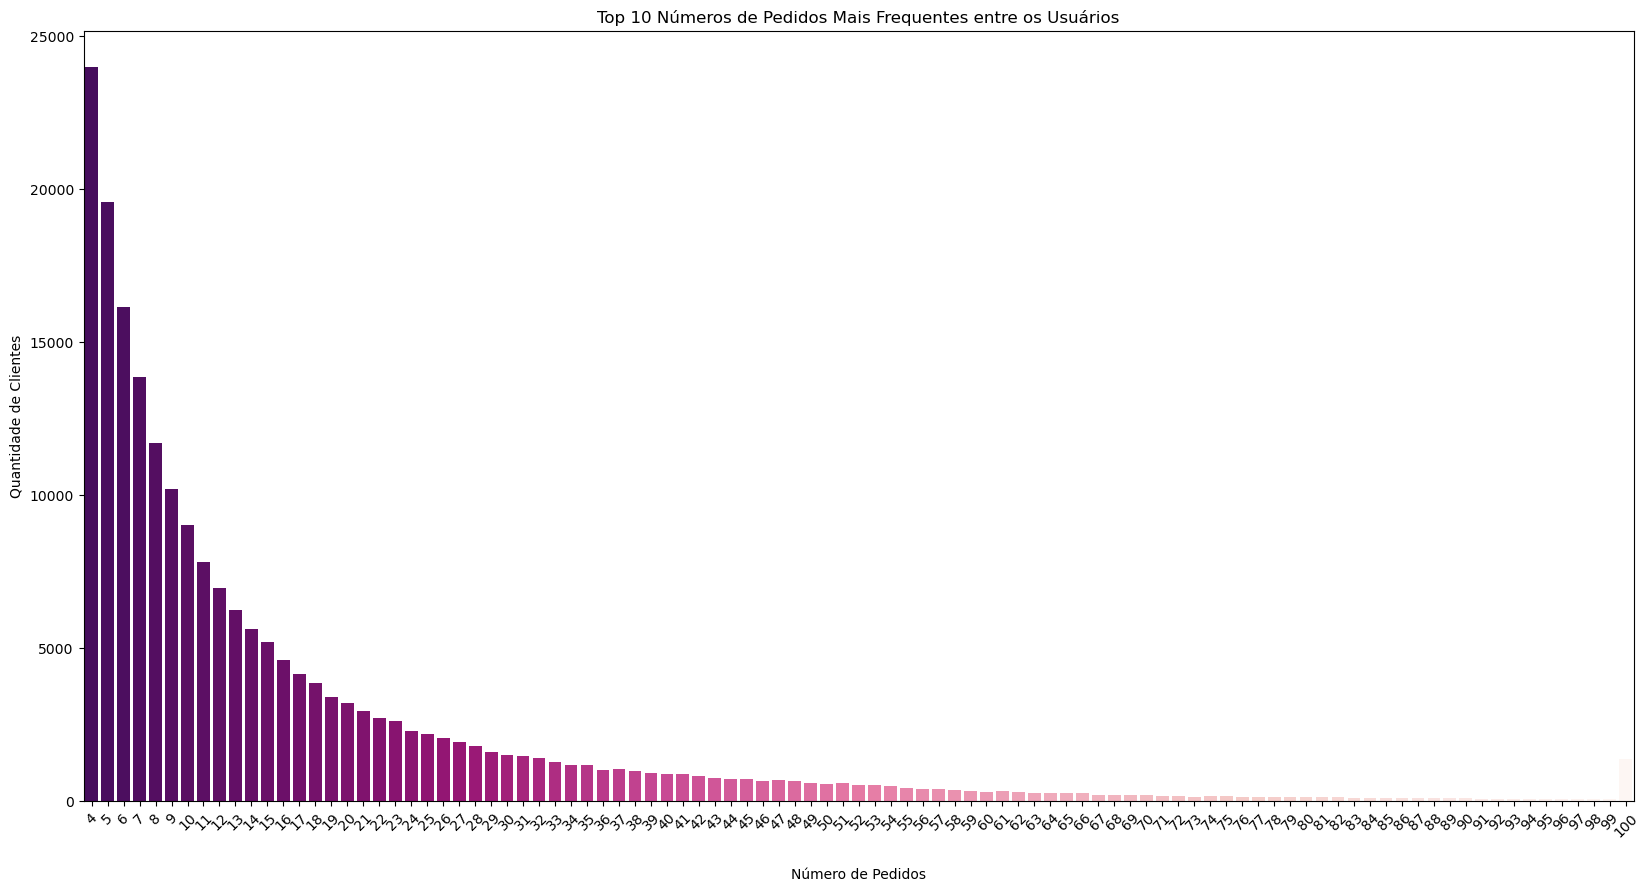

In [37]:
plt.figure(figsize=(20,10))
plt.title('Top 10 Números de Pedidos Mais Frequentes entre os Usuários')
ax = sns.barplot(data=freq_qtd_pedidos, x='order_number', y='count', palette='RdPu_r')
plt.xlabel('Número de Pedidos', labelpad=20)
plt.xticks(rotation=45)
plt.ylabel('Quantidade de Clientes')
plt.show()

<b>O número de pedidos mais frequente entre os usuários é 4 pedidos. Logo após a quantidade de pedidos por clientes mais comuns é 5 e 6 pedidos.</b>

#### 2- Qual Dia da Semana Tem o Maior Número de Pedidos?

In [38]:
freq_dow = df_pedidos['order_dow'].value_counts().sort_values(ascending=False)

In [39]:
freq_dow = freq_dow.to_frame().reset_index()

In [40]:
freq_dow

,order_dow,count
0,0,600905
1,1,587478
2,2,467260
3,5,453368
4,6,448761
5,3,436972
6,4,426339


In [41]:
dias_da_semana = {
    0:'Domingo',
    1:'Segunda',
    2:'Terça',
    3:'Quarta',
    4:'Quinta',
    5:'Sexta',
    6:'Sábado'
}

freq_dow['dia_semana'] = freq_dow['order_dow'].map(dias_da_semana)

In [42]:
freq_dow

,order_dow,count,dia_semana
0,0,600905,Domingo
1,1,587478,Segunda
2,2,467260,Terça
3,5,453368,Sexta
4,6,448761,Sábado
5,3,436972,Quarta
6,4,426339,Quinta


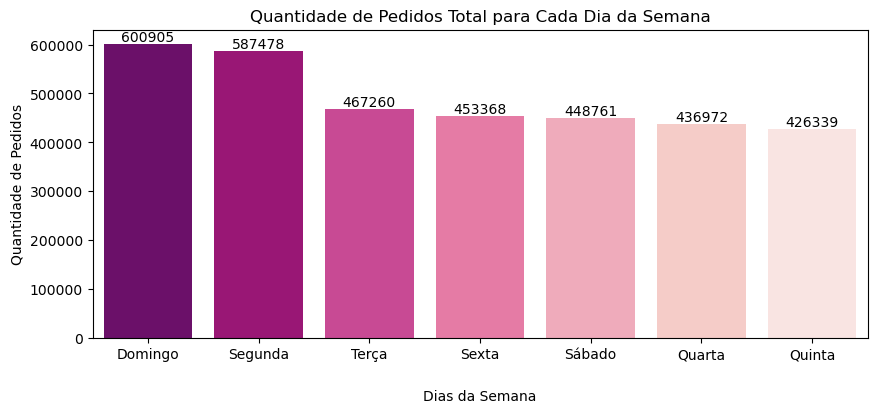

In [43]:
plt.figure(figsize=(10,4))
plt.title('Quantidade de Pedidos Total para Cada Dia da Semana')
ax = sns.barplot(data=freq_dow, x='dia_semana', y='count', palette='RdPu_r')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=10)
plt.xlabel('Dias da Semana', labelpad=20)
plt.ylabel('Quantidade de Pedidos')
plt.show()

<b>O dia com mais pedidos é Domingo, representado pelo dia 0. Logo em seguida a Segunda-feira representada pelo 1.</b>

#### 3 - Qual Hora do Dia Tem o Maior Número de Pedidos?

In [44]:
freq_hod = df_pedidos['order_hour_of_day'].value_counts().sort_values()

In [45]:
freq_hod = freq_hod.to_frame().reset_index()

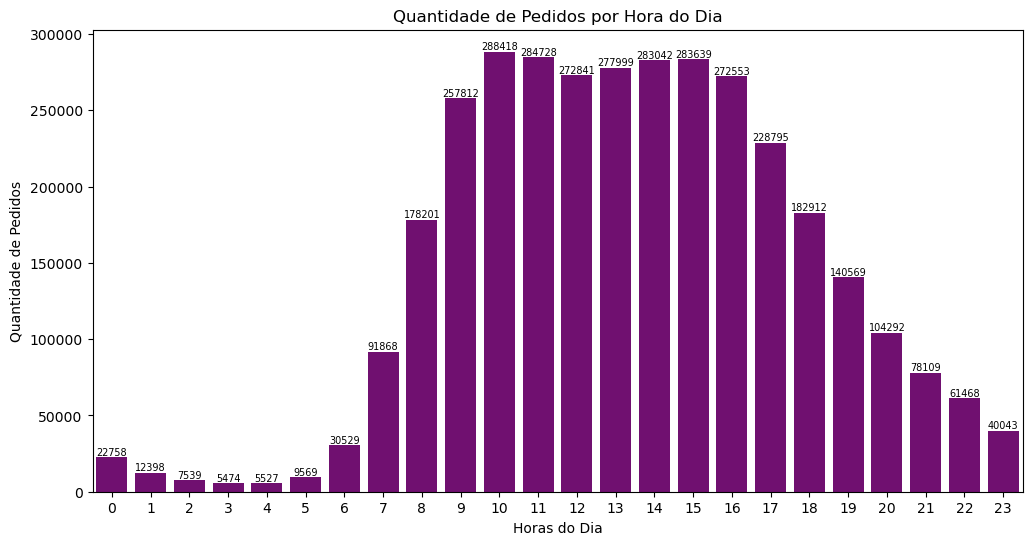

In [46]:
plt.figure(figsize=(12,6))
plt.title('Quantidade de Pedidos por Hora do Dia')
ax = sns.barplot(data=freq_hod, x='order_hour_of_day', y='count', color='Purple')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=7)
plt.xlabel('Horas do Dia')
plt.ylabel('Quantidade de Pedidos')
plt.show()

<b>O horário que tem mais pedidos realizados é as 10 da manhã. Logo em seguida as 11 da manhã.</b>

#### 4- Qual Departamento Tem o Maior Número de Pedidos?

In [47]:
freq_departamentos = df_transacoes['department'].value_counts().sort_values(ascending=False)

In [48]:
freq_departamentos = freq_departamentos.to_frame().reset_index()

In [49]:
freq_departamentos.head()

,department,count
0,produce,9479291
1,dairy eggs,5414016
2,snacks,2887550
3,beverages,2690129
4,frozen,2236432


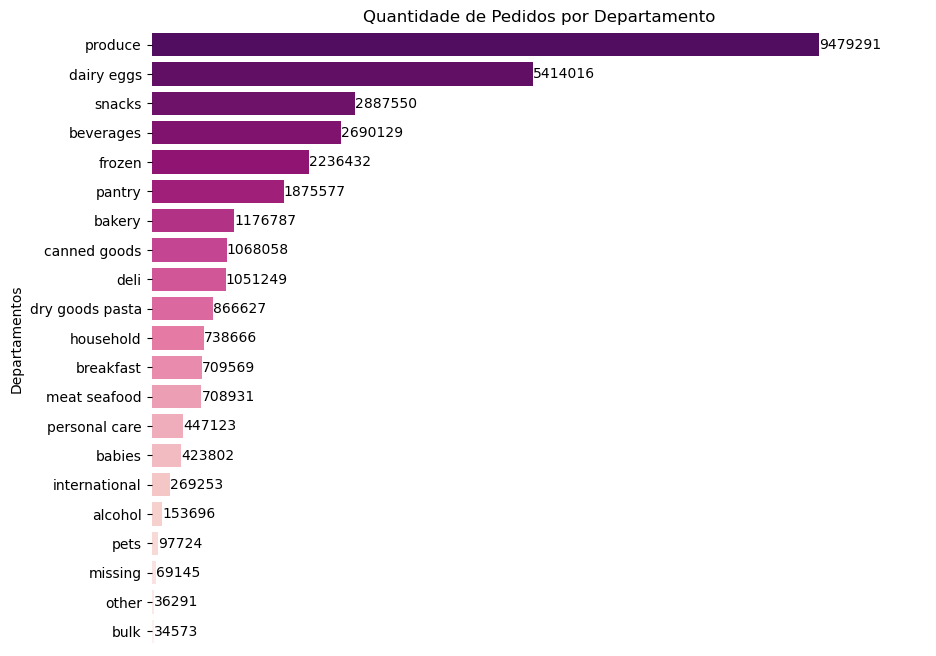

In [50]:
plt.figure(figsize=(10,8))
plt.title('Quantidade de Pedidos por Departamento')
ax = sns.barplot(data=freq_departamentos, x='count', y='department', palette='RdPu_r')
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.4, p.get_y() + p.get_height()/2, int(width), va='center', fontsize=10)
plt.ylabel('Departamentos')
ax.xaxis.set_visible(False)
sns.despine(left=True, bottom=True)
plt.xlim(0, 11000000)
plt.show()

<b>O departamento <i>produce</i> tem a maior quantidade de pedidos realizados.</b>

### 5 - Quais os 20 Principais Corredores Por Frequência de Pedidos?

In [51]:
freq_corredores = df_transacoes['aisle'].value_counts().sort_values(ascending=False)

In [52]:
freq_corredores = freq_corredores.to_frame().reset_index()

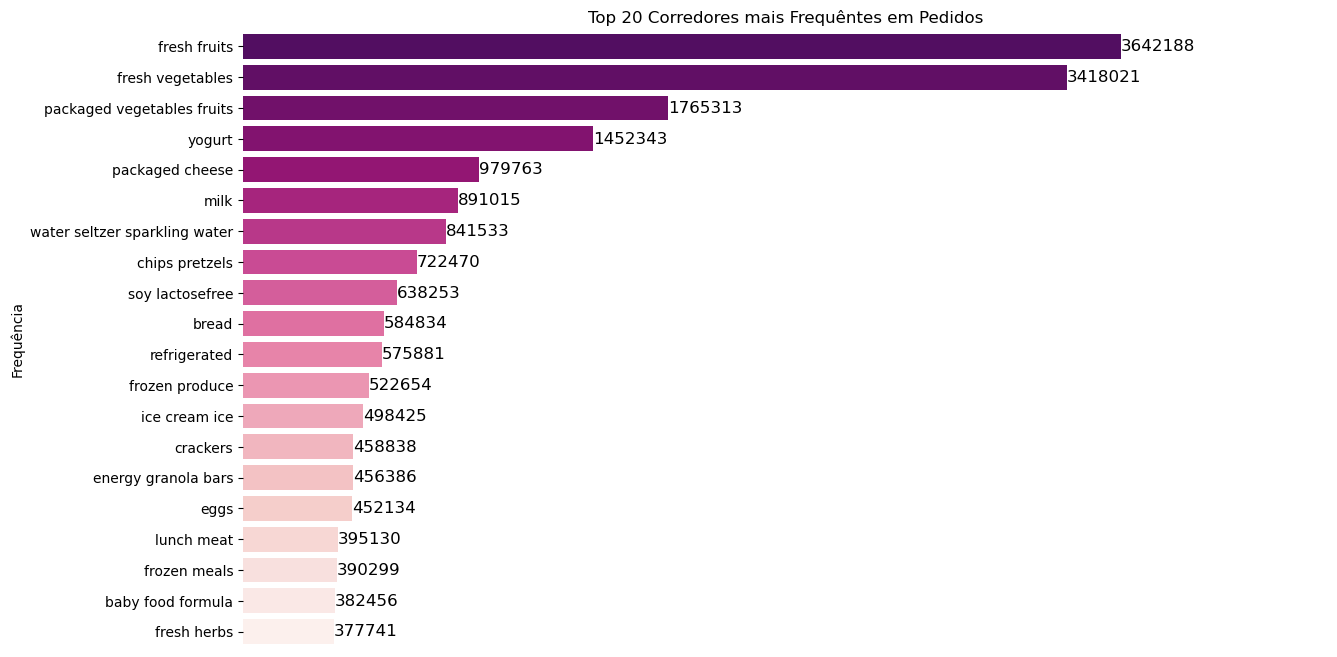

In [53]:
plt.figure(figsize=(14,8))
plt.title('Top 20 Corredores mais Frequêntes em Pedidos')
ax = sns.barplot(data=freq_corredores.head(20), x='count', y='aisle', palette='RdPu_r')
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.2, p.get_y() + p.get_height()/2, int(width), va='center', fontsize=12)
plt.xlabel('Corredor')
plt.ylabel('Frequência')
ax.xaxis.set_visible(False)
sns.despine(left=True, bottom=True)
plt.xlim(1000, 4500000)
plt.show()

<b>O gráfico apresenta os 20 corredores com mais frequência de compras. Fresh fruits é o corredor mais movimentado.</b>

#### 6 - Quais os 20 Principais Produtos Por Frequência de Pedidos?

In [54]:
freq_produtos = df_transacoes['product_name'].value_counts().sort_values(ascending=False)

In [55]:
freq_produtos = freq_produtos.to_frame().reset_index()

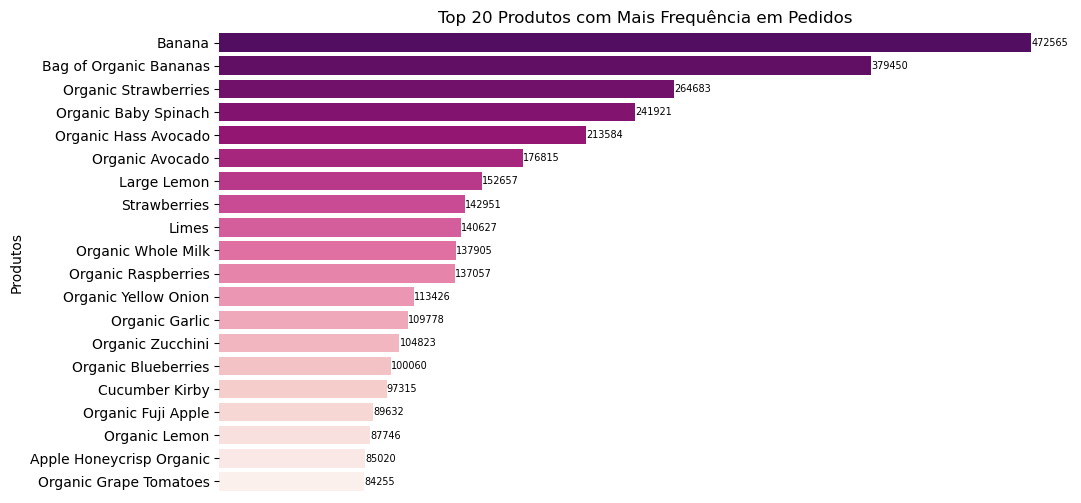

In [56]:
plt.figure(figsize=(11,6))
plt.title('Top 20 Produtos com Mais Frequência em Pedidos')
ax = sns.barplot(data=freq_produtos.head(20), x='count', y='product_name', palette='RdPu_r')
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.2, p.get_y() + p.get_height()/2, int(width), va='center', fontsize=7)
plt.ylabel('Produtos')
ax.xaxis.set_visible(False)
sns.despine(left=True, bottom=True)
plt.show()

<b>O gráfico apresenta os 20 produtos mais presentes nos pedidos, tendo banana como o produto mais vendido com uma margem considerável.</b>

#### 7- Faça a Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (Reorder)

In [57]:
products_total_reorders = df_transacoes.groupby('product_name')['reordered'].agg(['count', 'sum']) 

In [58]:
products_total_reorders = products_total_reorders.reset_index().rename(columns={'count':'total', 'sum':'reorders_sum'})

In [59]:
products_total_reorders = products_total_reorders.sort_values('total', ascending=False)

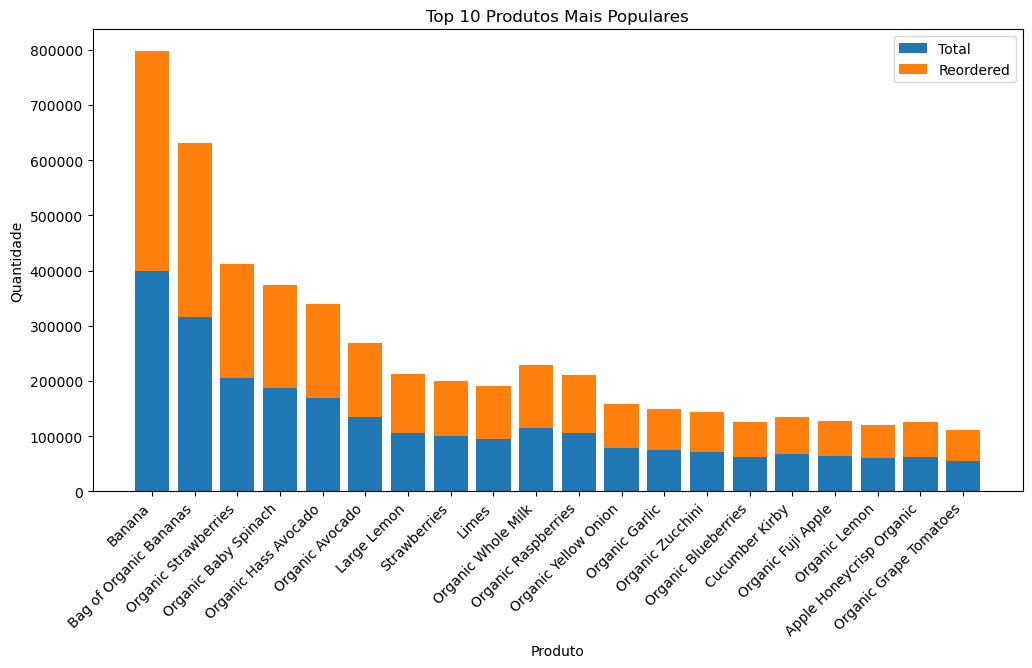

In [62]:
plt.figure(figsize=(12,6)) 
plt.title('Top 10 Produtos Mais Populares') 
plt.bar( products_total_reorders.head(20)['product_name'], 
        products_total_reorders.head(20)['total'], 
        label='Total' ) 
plt.bar( products_total_reorders.head(20)['product_name'], 
        products_total_reorders.head(20)['reorders_sum'],
        bottom=products_total_reorders.head(20)['reorders_sum'],
        label='Reordered' ) 
plt.xlabel('Produto') 
plt.ylabel('Quantidade') 
plt.xticks(rotation=45, ha='right') 
plt.legend() 
plt.show()

#### 8- Análise de Reorder Por Departamento ao Longo do Tempo

In [63]:
departmento_reorders_med = df_transacoes.groupby('department')['reordered'].agg('mean')

In [64]:
departmento_reorders_med = departmento_reorders_med.reset_index()

In [65]:
departmento_reorders_med.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


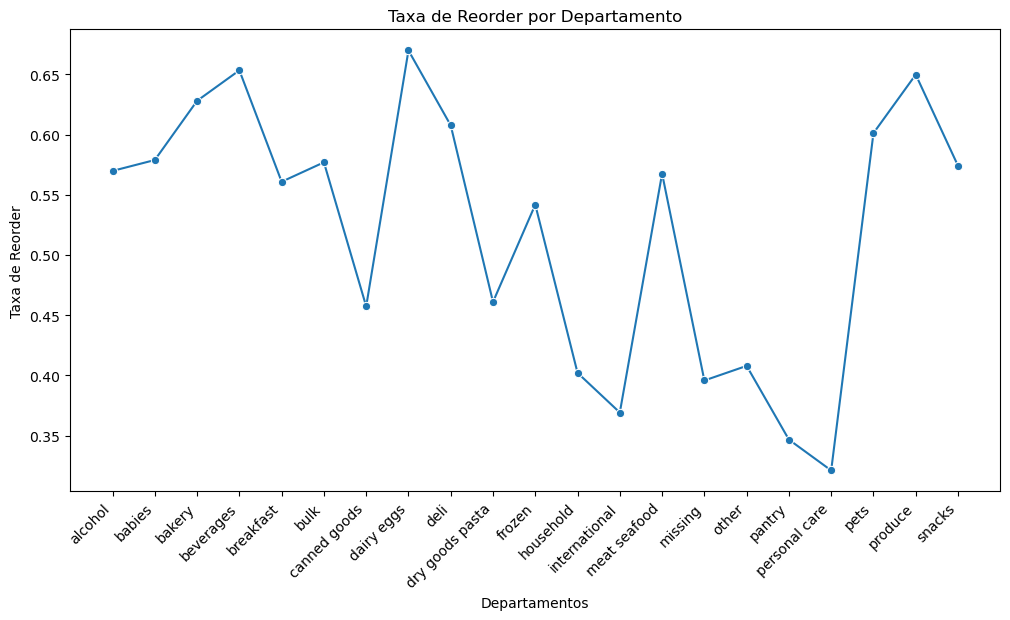

In [66]:
plt.figure(figsize=(12,6))
plt.title('Taxa de Reorder por Departamento')
ax = sns.lineplot(data=departmento_reorders_med, x='department', y='reordered', marker='o')
plt.xlabel('Departamentos')
plt.ylabel('Taxa de Reorder')
plt.xticks(rotation=45, ha='right')
plt.show()

#### 9 - Análise de Reorder Por Corredor

In [68]:
corredor_reorders_med = df_transacoes.groupby('aisle')['reordered'].agg('mean')

In [69]:
corredor_reorders_med = corredor_reorders_med.reset_index()

In [73]:
corredor_reorders_med = corredor_reorders_med.sort_values('reordered', ascending=False)

In [74]:
corredor_reorders_med.head()

,aisle,reordered
83,milk,0.781428
131,water seltzer sparkling water,0.729593
50,fresh fruits,0.718104
41,eggs,0.705366
119,soy lactosefree,0.692551


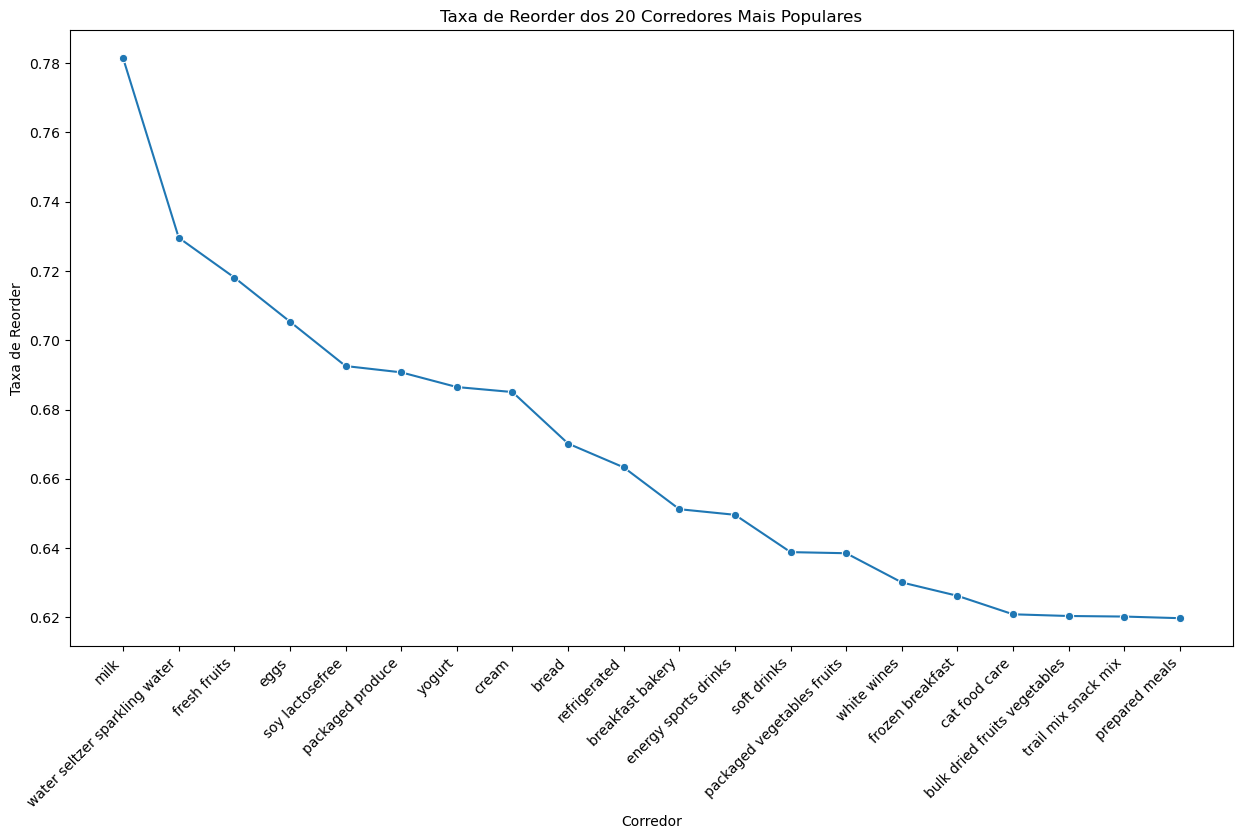

In [76]:
plt.figure(figsize=(15,8))
plt.title('Taxa de Reorder dos 20 Corredores Mais Populares')
ax = sns.lineplot(data=corredor_reorders_med.head(20), x='aisle', y='reordered', marker='o')
plt.xlabel('Corredor')
plt.ylabel('Taxa de Reorder')
plt.xticks(rotation=45, ha='right')
plt.show()

### Implementação do Algoritmo Apriori

In [77]:
df_carrinho.head()

,Id_Pedido,Produtos
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"


In [78]:
carrinho_tup = [tuple(row) for row in df_carrinho['Produtos'].tolist()]

Algoritmo Apriori \
Support = 0.01 \
Confidence = 0.2

In [79]:
%%time
itemsets_ap, rules_ap = apriori(carrinho_tup[:500000], min_support = 0.01, min_confidence = 0.2)

CPU times: total: 4.31 s
Wall time: 4.31 s


In [80]:
rules_ap

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

In [81]:
# Pegando penas alguns itens para análise
item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [82]:
# Listas para as métricas
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [83]:
for i in range(len(temp)):
    # Support A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)

    # Support B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)

    # Support de A e B
    if tuple([temp['itemA'][i], temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i], temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i], temp['itemA'][i]])] / 500000)

    # Confidence
    confidence_AB.append(support_AB[i] / support_A[i])

    # Calcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [85]:
# Dataframe com as regras de associação
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(df_produtos, on = 'product_id', how = 'left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id', 'product_name', 'aisle_id', 'department_id'], axis=1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(df_produtos, on = 'product_id', how = 'left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id', 'product_name', 'aisle_id', 'department_id'], axis=1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [86]:
df_rules_ap

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
2,Organic Strawberries,Banana,0.082550,0.147194,0.017596,0.213156,1.448127
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


In [87]:
# Ordenando por Confidence
df_rules_ap.sort_values(by='Confidence_AB', ascending=False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


In [88]:
# Ordenando por Lift
df_rules_ap.sort_values(by='Lift_AB', ascending=False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356
